In [72]:
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import randint as sp_randint
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from Lacoste_utils import add_monthly_UAE_holiday_count,get_lag_features, create_peak_calendar,merge_peak_calendar_info,create_monthly_seasonal_features,get_rate_of_sale_monthly,get_monthly_seasonality_index,get_moving_stats_features
import category_encoders as ce
import seaborn as sns

In [73]:
from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta
from dateutil.relativedelta import relativedelta
from typing import Optional, List, Tuple,  Callable, Dict, Union
import re
import os
import joblib
import holidays
import pickle
import fsspec

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# !pip install category_encoders

In [74]:
brand = 'LACOSTE'
country = 'UAE'
data_start_date = '2023-01-01'
train_end_date="2024-10-31"
cutoff_month="2025-07"
cut_off_date='2025-07-31'
data_end_date = '2026-12-31'

target = 'units'
fc_horizon=24
# Starting date
dt = datetime.strptime(train_end_date, "%Y-%m-%d")
date=dt + relativedelta(day=1)+relativedelta(months=fc_horizon)
horizon_end_date=date.strftime("%Y-%m-%d")
fc_start_date=dt + relativedelta(day=1)+relativedelta(months=1)
fc_start_date=fc_start_date.strftime("%Y-%m-%d")

base_vars = {"key": "key",
             "target": "target",
             "date": "date"}


gcs_path = "gs://trd-sf-ntb"
experiment_name ="model_pipeline"  # or something like f"exp_{datetime.now():%Y%m%d_%H%M%S}"
file_input1 = "monthly_temporal_features.parquet"
file_input2 = "monthly_lever_features.parquet"
file_input3 = "monthly_features_mmm_faces.parquet"
file_input4= "store_features.parquet"
file_input5="calendar_features.parquet"
file_output="feature_store.parquet"

# full_path = f"{gcs_path}/{target}/{brand}/{fc_horizon}/{experiment_name}/{file_input5}"

In [75]:
fc_start_date, horizon_end_date

('2024-11-01', '2026-10-01')

In [76]:
def eda_features(df_input: pd.DataFrame, feature_name: str):
    '''
    feature_name can only be following : temporal, promotion, marketing, store
    '''
    print(f"------EDA on {feature_name} features------------------")
    try:
        print(f"min & max dates {df_input.date.min().date()},{df_input.date.max().date()}",end="\n\n")
    except:
        pass
    print(f"shape of dataset : {df_input.shape}",end="\n\n")
    print(f"{feature_name} features: {df_input.columns.values}",end="\n\n")
    print(f"missing values :\n{df_input.isnull().sum()}")
    

### Temporal features

In [77]:
# Construct full dynamic path

full_path1 = f"{gcs_path}/{target}/{brand}/{experiment_name}/{cutoff_month}/{file_input1}"
print(full_path1)

# Save the DataFrame
df = pd.read_parquet(full_path1)


gs://trd-sf-ntb/units/LACOSTE/model_pipeline/2025-07/monthly_temporal_features.parquet


In [78]:
df = df[df['date']<=data_end_date]
# cut_off_date=str(df.date.max().date())
try:
    df.drop(columns = ['ppu', 'business_type', 'is_month_start', 'is_month_end', 'days_in_month'], inplace = True)
except:
    pass
eda_features(df,"temporal")

------EDA on temporal features------------------
min & max dates 2023-01-01,2025-07-01

shape of dataset : (331, 28)

temporal features: ['key' 'date' 'target' 'holiday_count' 'month' 'quarter' 'year'
 'fourier_year_sin' 'fourier_year_cos' 'Lag12_y' 'MA6_y' 'STD6_y' 'EMA6_y'
 'Seasonality_Index' 'rate_of_sale' 'UAE_shopping_peak_ratio'
 'festive_peak_flag' 'target_seasonal_monthly' 'target_seasonal_quarterly'
 'year_month' 'deriv_1_pct' 'deriv_2_pct' 'deriv_3_pct' 'deriv_6_pct'
 'monthly_max_qty' 'monthly_min_qty' 'deriv_1_flag' 'deriv_2_trend_flag']

missing values :
key                          0
date                         0
target                       0
holiday_count                0
month                        0
quarter                      0
year                         0
fourier_year_sin             0
fourier_year_cos             0
Lag12_y                      0
MA6_y                        0
STD6_y                       0
EMA6_y                       0
Seasonality_Index     

In [79]:
df["Lag12_y"].value_counts()

Lag12_y
1732.483384    144
3799.000000      2
1816.000000      2
771.000000       2
4283.000000      1
              ... 
1031.000000      1
1064.000000      1
821.000000       1
913.000000       1
315.000000       1
Name: count, Length: 185, dtype: int64

In [80]:
df[df["Lag12_y"]==df["Lag12_y"].value_counts().reset_index()["Lag12_y"][0]]

,key,date,target,holiday_count,month,quarter,year,fourier_year_sin,fourier_year_cos,Lag12_y,...,target_seasonal_quarterly,year_month,deriv_1_pct,deriv_2_pct,deriv_3_pct,deriv_6_pct,monthly_max_qty,monthly_min_qty,deriv_1_flag,deriv_2_trend_flag
0,52003,2023-01-01,4069,1,1,1,2023,0.500000,8.660254e-01,1732.483384,...,1730.617021,2023-01,0.00,0.00,0.00,0.00,4069.0,1744.0,0,0
1,52003,2023-02-01,2194,0,2,1,2023,0.866025,5.000000e-01,1732.483384,...,1730.617021,2023-02,0.00,0.00,0.00,0.00,4069.0,1744.0,0,0
2,52003,2023-03-01,3030,0,3,1,2023,1.000000,6.123234e-17,1732.483384,...,1730.617021,2023-03,-46.08,0.00,0.00,0.00,4069.0,1744.0,0,0
3,52003,2023-04-01,3051,4,4,2,2023,0.866025,-5.000000e-01,1732.483384,...,1780.340206,2023-04,38.10,-182.68,0.00,0.00,4069.0,1744.0,1,-1
4,52003,2023-05-01,3116,0,5,2,2023,0.500000,-8.660254e-01,1732.483384,...,1780.340206,2023-05,0.69,-98.19,-25.02,0.00,4069.0,1744.0,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,52086,2025-01-01,347,1,1,1,2025,0.500000,8.660254e-01,1732.483384,...,1730.617021,2025-01,-53.58,-163.76,-1.60,434.78,548.0,46.0,1,-1
325,52086,2025-02-01,111,0,2,1,2025,0.866025,5.000000e-01,1732.483384,...,1730.617021,2025-02,41.06,-176.63,20.49,10.16,548.0,46.0,1,-1
326,52086,2025-03-01,339,2,3,1,2025,1.000000,6.123234e-17,1732.483384,...,1730.617021,2025-03,-68.01,-265.64,-79.06,-36.57,548.0,46.0,1,-1
327,52086,2025-04-01,376,1,4,2,2025,0.866025,-5.000000e-01,1732.483384,...,1780.340206,2025-04,205.41,-402.03,37.80,35.60,548.0,46.0,1,-1


### Calendar features

In [81]:
full_path5 = f"{gcs_path}/{target}/{brand}/{experiment_name}/{cutoff_month}/{file_input5}"

In [82]:
df_calendar_features=pd.read_parquet(full_path5)

In [83]:
eda_features(df_calendar_features,"calendar_features")

------EDA on calendar_features features------------------
min & max dates 2023-01-01,2026-10-01

shape of dataset : (46, 8)

calendar_features features: ['ramadan_period' 'public_holidays' 'is_high_sales_intent_flag'
 'shopping_event_code' 'fashion_week_season' 'count_of_days' 'uae_seasons'
 'date']

missing values :
ramadan_period               0
public_holidays              0
is_high_sales_intent_flag    0
shopping_event_code          0
fashion_week_season          0
count_of_days                0
uae_seasons                  0
date                         0
dtype: int64


In [84]:
df_calendar_features

,ramadan_period,public_holidays,is_high_sales_intent_flag,shopping_event_code,fashion_week_season,count_of_days,uae_seasons,date
0,0,1,0,15,0,31,1,2023-01-01
1,0,0,0,28,28,28,1,2023-02-01
2,24,0,0,0,0,31,2,2023-03-01
3,28,3,9,9,0,30,2,2023-04-01
4,0,0,0,0,0,31,2,2023-05-01
5,0,5,30,30,0,30,3,2023-06-01
6,0,0,31,31,0,31,3,2023-07-01
7,0,0,31,31,0,31,3,2023-08-01
8,0,0,0,0,30,30,3,2023-09-01
9,0,0,0,0,0,31,4,2023-10-01


### Promotional features

In [85]:
# Construct full dynamic path
full_path2 = f"{gcs_path}/{target}/{brand}/{experiment_name}/{cutoff_month}/{file_input2}"
# Save the DataFrame
promo_df = pd.read_parquet(full_path2)

promo_df.rename(columns={'locationId': 'key'}, inplace=True)
promo_df['key'] = promo_df['key'].astype(str)
promo_df
eda_features(promo_df,"Promotion")

------EDA on Promotion features------------------
min & max dates 2023-07-01,2026-10-01

shape of dataset : (219, 9)

Promotion features: ['key' 'date' 'distinct_discount_levels' 'avg_discount' 'max_discount'
 'min_discount' 'avg_promo_duration' 'promo_days_in_month'
 'percentage_products_on_promo']

missing values :
key                             0
date                            0
distinct_discount_levels        0
avg_discount                    0
max_discount                    0
min_discount                    0
avg_promo_duration              0
promo_days_in_month             0
percentage_products_on_promo    0
dtype: int64


In [86]:
promo_df.head(2)

,key,date,distinct_discount_levels,avg_discount,max_discount,min_discount,avg_promo_duration,promo_days_in_month,percentage_products_on_promo
0,52003,2023-07-01,5,29.54,50.0,25.0,45.64,31,31.81
1,52003,2023-08-01,5,29.59,50.0,25.0,29.98,14,31.81


### Store features

In [87]:
# Construct full dynamic path

full_path4 = f"{gcs_path}/{target}/{brand}/{experiment_name}/{cutoff_month}/{file_input4}"
# Save the DataFrame
stores_df = pd.read_parquet(full_path4)
stores_df=stores_df.rename(columns={"store":"key"})
stores_df.key=stores_df.key.astype(str)
str_cnt=len(stores_df.key.unique())
print(f"Total store counts: {str_cnt}")
str_vals=stores_df.key.unique()
print(f"List of unique store id: {str_vals}")
eda_features(stores_df,"Store")

Total store counts: 12
List of unique store id: ['52010' '52085' '52043' '52020' '52003' '52074' '52052' '52086' '52082'
 '52071' '52012' '52009']
------EDA on Store features------------------
shape of dataset : (12, 9)

Store features: ['key' 'city' 'is_ecom_fullfillment_loc' 'channel' 'total_square_ft'
 'selling_square_ft' 'store_format' 'total_square_ft_cat'
 'selling_square_ft_cat']

missing values :
key                         0
city                        0
is_ecom_fullfillment_loc    0
channel                     0
total_square_ft             0
selling_square_ft           0
store_format                0
total_square_ft_cat         0
selling_square_ft_cat       0
dtype: int64


In [88]:
stores_df.head(2)

,key,city,is_ecom_fullfillment_loc,channel,total_square_ft,selling_square_ft,store_format,total_square_ft_cat,selling_square_ft_cat
0,52010,ABU DHABI,True,Retail,203.0,163.0,1.000000000,3,3
1,52085,ABU DHABI,True,Retail,158.0,121.0,1.000000000,2,2


### Marketing features

In [89]:
full_path3 = f"{gcs_path}/{target}/{brand}/{experiment_name}/{cutoff_month}/{file_input3}"
mmm_df = pd.read_parquet(full_path3)
columns_to_keep = ['date','total_cost_usd_facebook','total_cost_usd_google',
                   'total_cost_usd_instagram','total_cost_usd_tiktok']
mmm_df = mmm_df[columns_to_keep]
int_mmm_df=mmm_df[mmm_df["date"]<=cut_off_date]
print(eda_features(mmm_df, "Marketing"))

mmm_df.head(2)

ext_mmm_df=mmm_df[mmm_df["date"]>cut_off_date]
ext_mmm_df.isnull().sum()
eda_features(ext_mmm_df,"Extended markting")

ext_mmm_df = pd.concat([ext_mmm_df]*str_cnt, ignore_index=True)
dates=ext_mmm_df.date.unique().tolist()
ext_mmm_df["key"]=""
for date in dates:
    ext_mmm_df.loc[ext_mmm_df["date"]==date,"key"]=list(str_vals)

eda_features(ext_mmm_df,"Extended marketing")

ext_mmm_df.head(2)

------EDA on Marketing features------------------
min & max dates 2023-03-01,2026-10-01

shape of dataset : (44, 5)

Marketing features: ['date' 'total_cost_usd_facebook' 'total_cost_usd_google'
 'total_cost_usd_instagram' 'total_cost_usd_tiktok']

missing values :
date                        0
total_cost_usd_facebook     0
total_cost_usd_google       0
total_cost_usd_instagram    0
total_cost_usd_tiktok       0
dtype: int64
None
------EDA on Extended markting features------------------
min & max dates 2025-08-01,2026-10-01

shape of dataset : (15, 5)

Extended markting features: ['date' 'total_cost_usd_facebook' 'total_cost_usd_google'
 'total_cost_usd_instagram' 'total_cost_usd_tiktok']

missing values :
date                        0
total_cost_usd_facebook     0
total_cost_usd_google       0
total_cost_usd_instagram    0
total_cost_usd_tiktok       0
dtype: int64
------EDA on Extended marketing features------------------
min & max dates 2025-08-01,2026-10-01

shape of dataset : (180

,date,total_cost_usd_facebook,total_cost_usd_google,total_cost_usd_instagram,total_cost_usd_tiktok,key
0,2025-08-01,5968.3788,20841.6381,5372.1818,0.0,52010
1,2025-09-01,7552.8655,11269.9509,5202.0545,0.0,52010


### Tourism features

In [90]:
df_tourism=pd.read_excel("Tourism.xlsx")

In [91]:
eda_features(df_tourism,"tourism")
df_tourism.year.max(),df_tourism.month.max()

------EDA on tourism features------------------
shape of dataset : (29, 3)

tourism features: ['year' 'month' 'tourists']

missing values :
year        0
month       0
tourists    0
dtype: int64


(2025, 'September')

In [92]:
month_dic={"JAN":1,"FEB":2,"MAR":3,"APR":4,"MAY":5,"JUN":6,"JUL":7,"AUG":8,"SEP":9,"OCT":10,"NOV":11,"DEC":12}
month_dic2={}
for i,j in zip([ x.capitalize() for x in month_dic.keys()],month_dic.values()):
    month_dic2[i]=j

df_tourism.head()

,year,month,tourists
0,2023,January,1470000
1,2023,February,1630000
2,2023,March,1570000
3,2023,April,1350000
4,2023,May,1370000


In [93]:
df_tourism["month"]=df_tourism["month"].apply(lambda x: x[:3])
df_tourism["month"]=df_tourism["month"].apply(lambda x: month_dic2[x])
df_tourism["date"]=df_tourism.apply(lambda row: str(row["year"])+"-"+str(row["month"])+"-01",axis=1)
df_tourism["date"]=df_tourism["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date() )
df_tourism["tourists"]=df_tourism["tourists"].astype(str).apply(lambda x: x.replace(',', '').replace('\xa0', '')).astype(int)
df_tourism['date'].apply(lambda x: type(x)).unique()


array([<class 'datetime.date'>], dtype=object)

In [94]:
start_date=df_tourism.loc[df_tourism.index.tolist()[-1],'date']+relativedelta(months=1)
last_date=df_tourism.loc[df_tourism.index.tolist()[-1],'date']+relativedelta(months=17)
period_range=pd.period_range(start=start_date, end=last_date, freq='M')
index=len(df_tourism.index)
for dt in period_range:
    dt=str(dt)+"-01"
    # print(dt)
    dt = datetime.strptime(dt, '%Y-%m-%d')
    df_tourism.loc[index,"date"]=dt.date()
    df_tourism.loc[index,"month"]=dt.month
    df_tourism.loc[index,"year"]=float(dt.year)
    df_tourism.loc[index,"tourists"]=df_tourism.loc[index-12,"tourists"]
    
    # df_tourism.loc[index,"tourists"]=df_tourism.loc[index-12,"tourists"]
    # df_tourism.loc[index,"date"]=df_tourism.loc[index-1,"date"] +relativedelta(months=1)
    index+=1
    

In [95]:
df_tourism["date"]=pd.to_datetime(df_tourism["date"])

In [96]:
df_tourism

,year,month,tourists,date
0,2023.0,1.0,1470000.0,2023-01-01
1,2023.0,2.0,1630000.0,2023-02-01
2,2023.0,3.0,1570000.0,2023-03-01
3,2023.0,4.0,1350000.0,2023-04-01
4,2023.0,5.0,1370000.0,2023-05-01
5,2023.0,6.0,1160000.0,2023-06-01
6,2023.0,7.0,1280000.0,2023-07-01
7,2023.0,8.0,1270000.0,2023-08-01
8,2023.0,9.0,1300000.0,2023-09-01
9,2023.0,10.0,1500000.0,2023-10-01


### Merged features

In [97]:
df.columns

Index(['key', 'date', 'target', 'holiday_count', 'month', 'quarter', 'year',
       'fourier_year_sin', 'fourier_year_cos', 'Lag12_y', 'MA6_y', 'STD6_y',
       'EMA6_y', 'Seasonality_Index', 'rate_of_sale',
       'UAE_shopping_peak_ratio', 'festive_peak_flag',
       'target_seasonal_monthly', 'target_seasonal_quarterly', 'year_month',
       'deriv_1_pct', 'deriv_2_pct', 'deriv_3_pct', 'deriv_6_pct',
       'monthly_max_qty', 'monthly_min_qty', 'deriv_1_flag',
       'deriv_2_trend_flag'],
      dtype='object')

In [98]:
print(f"temporal features {df.date.min()},{df.date.max()}")
print(f"ramadan_features {df_calendar_features.date.dt.date.min(),df_calendar_features.date.dt.date.max()}")
print(f"trimmed marketing features {int_mmm_df.date.min()},{int_mmm_df.date.max()}")
print()
print(f"promotion features {promo_df.date.min()},{promo_df.date.max()}")
# print(f"store features {stores_df.date.min()},{stores_df.date.max()}")
start_date=max([df.date.min().date(),int_mmm_df.date.min().date(),promo_df.date.min().date()])
print(start_date)

temporal features 2023-01-01 00:00:00,2025-07-01 00:00:00
ramadan_features (datetime.date(2023, 1, 1), datetime.date(2026, 10, 1))
trimmed marketing features 2023-03-01 00:00:00,2025-07-01 00:00:00

promotion features 2023-07-01 00:00:00,2026-10-01 00:00:00
2023-07-01


In [99]:
df=df[df["date"].dt.date>=start_date]
df=df.merge(df_calendar_features,on="date",how="left")
temp_mm = df.merge(int_mmm_df, on = 'date', how = 'left').fillna(0)
print(temp_mm.columns)

temp_ext_mm=pd.concat([temp_mm,ext_mmm_df],axis=0,join="outer")
print(temp_ext_mm.columns)

df_temp_mm_str=temp_ext_mm.merge(stores_df, on ="key", how="left").sort_values(["key","date"]).reset_index(drop=True)
print(df_temp_mm_str.columns)
df=df_temp_mm_str.merge(promo_df,on=["key","date"],how="left")
print(df.columns)
df.isnull().sum()

Index(['key', 'date', 'target', 'holiday_count', 'month', 'quarter', 'year',
       'fourier_year_sin', 'fourier_year_cos', 'Lag12_y', 'MA6_y', 'STD6_y',
       'EMA6_y', 'Seasonality_Index', 'rate_of_sale',
       'UAE_shopping_peak_ratio', 'festive_peak_flag',
       'target_seasonal_monthly', 'target_seasonal_quarterly', 'year_month',
       'deriv_1_pct', 'deriv_2_pct', 'deriv_3_pct', 'deriv_6_pct',
       'monthly_max_qty', 'monthly_min_qty', 'deriv_1_flag',
       'deriv_2_trend_flag', 'ramadan_period', 'public_holidays',
       'is_high_sales_intent_flag', 'shopping_event_code',
       'fashion_week_season', 'count_of_days', 'uae_seasons',
       'total_cost_usd_facebook', 'total_cost_usd_google',
       'total_cost_usd_instagram', 'total_cost_usd_tiktok'],
      dtype='object')
Index(['key', 'date', 'target', 'holiday_count', 'month', 'quarter', 'year',
       'fourier_year_sin', 'fourier_year_cos', 'Lag12_y', 'MA6_y', 'STD6_y',
       'EMA6_y', 'Seasonality_Index', 'rate_of_sa

key                               0
date                              0
target                          180
holiday_count                   180
month                           180
quarter                         180
year                            180
fourier_year_sin                180
fourier_year_cos                180
Lag12_y                         180
MA6_y                           180
STD6_y                          180
EMA6_y                          180
Seasonality_Index               180
rate_of_sale                    180
UAE_shopping_peak_ratio         180
festive_peak_flag               180
target_seasonal_monthly         180
target_seasonal_quarterly       180
year_month                      180
deriv_1_pct                     180
deriv_2_pct                     180
deriv_3_pct                     180
deriv_6_pct                     180
monthly_max_qty                 180
monthly_min_qty                 180
deriv_1_flag                    180
deriv_2_trend_flag          

In [100]:
df.reset_index(inplace=True,drop=True)
df.sort_values(["key","date"],inplace=True)

In [101]:
df.date.max()

Timestamp('2026-10-01 00:00:00')

In [102]:
# imputing promotion features with 0 value, feature avg_promo_duration missing in FACES
df[['percentage_products_on_promo', 'distinct_discount_levels', 'avg_discount',
       'max_discount', 'min_discount', 'avg_promo_duration','promo_days_in_month']]=\
df[['percentage_products_on_promo', 'distinct_discount_levels', 'avg_discount',
       'max_discount', 'min_discount', 'avg_promo_duration','promo_days_in_month']].fillna(0)

### Feature creation for mentioned horizon months

In [103]:
df_fut_hz=df[(df["date"]>cut_off_date) & (df["date"]<=horizon_end_date)]
print(df_fut_hz.date.min().date(),df_fut_hz.date.max().date())

df_fut_hz=add_monthly_UAE_holiday_count(df_fut_hz[["date"]],'date')

2025-08-01 2026-10-01


In [104]:
df_fut_hz

,date,holiday_count
0,2025-08-01,0
1,2025-09-01,1
2,2025-10-01,0
3,2025-11-01,0
4,2025-12-01,2
...,...,...
175,2026-06-01,1
176,2026-07-01,0
177,2026-08-01,1
178,2026-09-01,0


In [105]:
df_fut_hz=merge_peak_calendar_info(df_fut_hz,start_date=data_start_date ,end_date=horizon_end_date)
df_fut_hz.festive_peak_flag.value_counts()

festive_peak_flag
0    168
1     12
Name: count, dtype: int64

In [106]:
df_fut_hz.columns

Index(['date', 'holiday_count', 'UAE_shopping_peak_ratio',
       'festive_peak_flag'],
      dtype='object')

In [107]:
df_fut_hz

,date,holiday_count,UAE_shopping_peak_ratio,festive_peak_flag
0,2025-08-01,0,0.000000,0
1,2025-09-01,1,0.033333,0
2,2025-10-01,0,0.000000,0
3,2025-11-01,0,0.366667,0
4,2025-12-01,2,1.000000,0
...,...,...,...,...
175,2026-06-01,1,0.000000,0
176,2026-07-01,0,1.000000,0
177,2026-08-01,1,0.000000,0
178,2026-09-01,0,0.033333,0


In [108]:
df[df["date"]>cut_off_date]["date"]

23    2025-08-01
24    2025-09-01
25    2025-10-01
26    2025-11-01
27    2025-12-01
         ...    
452   2026-06-01
453   2026-07-01
454   2026-08-01
455   2026-09-01
456   2026-10-01
Name: date, Length: 180, dtype: datetime64[ns]

In [109]:
df_fut_hz["month"]=pd.to_datetime(df_fut_hz["date"]).dt.month
df_fut_hz["year"]=pd.to_datetime(df_fut_hz["date"]).dt.year
df_fut_hz["quarter"]=pd.to_datetime(df_fut_hz["date"]).dt.quarter

df.loc[df["date"]>cut_off_date,"month"]=df_fut_hz["month"].values.tolist()
df.loc[df["date"]>cut_off_date,"year"]=df_fut_hz["year"].values.tolist()
df.loc[df["date"]>cut_off_date,"quarter"]=df_fut_hz["quarter"].values.tolist()

df.loc[df["date"]>cut_off_date,"UAE_shopping_peak_ratio"]=df_fut_hz["UAE_shopping_peak_ratio"].values.tolist()

df.loc[df["date"]>cut_off_date,"festive_peak_flag"]=df_fut_hz["festive_peak_flag"].values.tolist()

df_fut_hz["fourier_year_sin"]=np.sin(2 * np.pi * df_fut_hz['month'] / 12)
df_fut_hz["fourier_year_cos"]=np.cos(2 * np.pi * df_fut_hz['month'] / 12)

df.loc[df["date"]>cut_off_date,"fourier_year_sin"]=df_fut_hz["fourier_year_sin"].values.tolist()
df.loc[df["date"]>cut_off_date,"fourier_year_cos"]=df_fut_hz["fourier_year_cos"].values.tolist()

df.loc[df["date"]>cut_off_date,"holiday_count"]=df_fut_hz["holiday_count"].values.tolist()



In [110]:
print(f"shape and max date:{df.shape},{df.date.max().date()}", end="\n\n")
print(f"missing values:\n{df.isnull().sum()}",end="\n\n")

shape and max date:(457, 54),2026-10-01

missing values:
key                               0
date                              0
target                          180
holiday_count                     0
month                             0
quarter                           0
year                              0
fourier_year_sin                  0
fourier_year_cos                  0
Lag12_y                         180
MA6_y                           180
STD6_y                          180
EMA6_y                          180
Seasonality_Index               180
rate_of_sale                    180
UAE_shopping_peak_ratio           0
festive_peak_flag                 0
target_seasonal_monthly         180
target_seasonal_quarterly       180
year_month                      180
deriv_1_pct                     180
deriv_2_pct                     180
deriv_3_pct                     180
deriv_6_pct                     180
monthly_max_qty                 180
monthly_min_qty                 180
deriv_1

In [111]:
qualt_features=['is_ecom_fullfillment_loc', 'city','channel', 'festive_peak_flag','month', 'quarter', 'year','store_format','total_square_ft_cat','selling_square_ft_cat','key']
print(f"qualitative features:\n{qualt_features}")

qualitative features:
['is_ecom_fullfillment_loc', 'city', 'channel', 'festive_peak_flag', 'month', 'quarter', 'year', 'store_format', 'total_square_ft_cat', 'selling_square_ft_cat', 'key']


In [112]:
for col in qualt_features:
    print(df[col].value_counts())

is_ecom_fullfillment_loc
True     310
False    147
Name: count, dtype: Int64
city
DUBAI        385
ABU DHABI     72
Name: count, dtype: int64
channel
Retail       350
Farfetch      67
Ecommerce     40
Name: count, dtype: int64
festive_peak_flag
0.0    410
1.0     47
Name: count, dtype: int64
month
10.0    46
7.0     45
9.0     45
8.0     44
6.0     36
3.0     35
4.0     35
5.0     35
11.0    34
12.0    34
1.0     34
2.0     34
Name: count, dtype: int64
quarter
3.0    134
4.0    114
2.0    106
1.0    103
Name: count, dtype: int64
year
2025.0    144
2024.0    137
2026.0    120
2023.0     56
Name: count, dtype: int64
store_format
1.000000000    310
5.000000000    107
2.000000000     40
Name: count, dtype: int64
total_square_ft_cat
2    152
4    120
1    107
3     78
Name: count, dtype: int64
selling_square_ft_cat
4    120
3    118
2    112
1    107
Name: count, dtype: int64
key
52009    40
52010    40
52012    40
52020    40
52043    40
52052    40
52071    40
52074    40
52003    38
5208

### Encoding

In [113]:
def target_encode_percentage_contribution(df_input: pd.DataFrame, cat_features: list, target_col: str) -> pd.DataFrame:
    # Total target sum across entire dataset
    total_target = int(df_input[target_col].sum())
   
    for col in cat_features:
        # Sum of target per category
        var=col+"_target_sum"
        df_n=df_input.dropna(subset=target_col)
        contrib_df = df_n.groupby(col).agg(var=('target',"sum")).reset_index()
        contrib_df=contrib_df.rename(columns={"var":var})

        # Compute percentage contribution
        contrib_df[f"{col}_target_pct"] = contrib_df[var].apply(lambda x:x / total_target)
        contrib_df.drop(columns=var,errors="ignore",inplace=True)
        # print(contrib_df.isnull().sum())
        # print(contrib_df)
        # Join back to original dataframe
        df_input = pd.merge(df_input,contrib_df, on=col, how="left")
        # print(df_input.isnull().sum())
    return df_input

 # peak_festive_flag, channel
df_encoding=df.copy()
# df=target_encode_percentage_contribution(df_encoding,["channel","festive_peak_flag","store_format",'key'],"target")

In [114]:
df[df["target"].isnull()]

,key,date,target,holiday_count,month,quarter,year,fourier_year_sin,fourier_year_cos,Lag12_y,...,store_format,total_square_ft_cat,selling_square_ft_cat,distinct_discount_levels,avg_discount,max_discount,min_discount,avg_promo_duration,promo_days_in_month,percentage_products_on_promo
23,52003,2025-08-01,NaN,0.0,8.0,3.0,2025.0,-8.660254e-01,-5.000000e-01,NaN,...,1.000000000,3,3,1.0,50.00,50.0,50.0,30.0,17.0,0.16
24,52003,2025-09-01,NaN,1.0,9.0,3.0,2025.0,-1.000000e+00,-1.836970e-16,NaN,...,1.000000000,3,3,0.0,0.00,0.0,0.0,0.0,0.0,0.00
25,52003,2025-10-01,NaN,0.0,10.0,4.0,2025.0,-8.660254e-01,5.000000e-01,NaN,...,1.000000000,3,3,0.0,0.00,0.0,0.0,0.0,0.0,0.00
26,52003,2025-11-01,NaN,0.0,11.0,4.0,2025.0,-5.000000e-01,8.660254e-01,NaN,...,1.000000000,3,3,0.0,0.00,0.0,0.0,0.0,0.0,0.00
27,52003,2025-12-01,NaN,2.0,12.0,4.0,2025.0,-2.449294e-16,1.000000e+00,NaN,...,1.000000000,3,3,4.0,34.67,40.0,25.0,7.0,23.0,36.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,52086,2026-06-01,NaN,1.0,6.0,2.0,2026.0,1.224647e-16,-1.000000e+00,NaN,...,5.000000000,1,1,1.0,40.00,40.0,40.0,5.0,2.0,8.31
453,52086,2026-07-01,NaN,0.0,7.0,3.0,2026.0,-5.000000e-01,-8.660254e-01,NaN,...,5.000000000,1,1,0.0,0.00,0.0,0.0,0.0,0.0,0.00
454,52086,2026-08-01,NaN,1.0,8.0,3.0,2026.0,-8.660254e-01,-5.000000e-01,NaN,...,5.000000000,1,1,0.0,0.00,0.0,0.0,0.0,0.0,0.00
455,52086,2026-09-01,NaN,0.0,9.0,3.0,2026.0,-1.000000e+00,-1.836970e-16,NaN,...,5.000000000,1,1,0.0,0.00,0.0,0.0,0.0,0.0,0.00


In [115]:
df.isnull().sum()

key                               0
date                              0
target                          180
holiday_count                     0
month                             0
quarter                           0
year                              0
fourier_year_sin                  0
fourier_year_cos                  0
Lag12_y                         180
MA6_y                           180
STD6_y                          180
EMA6_y                          180
Seasonality_Index               180
rate_of_sale                    180
UAE_shopping_peak_ratio           0
festive_peak_flag                 0
target_seasonal_monthly         180
target_seasonal_quarterly       180
year_month                      180
deriv_1_pct                     180
deriv_2_pct                     180
deriv_3_pct                     180
deriv_6_pct                     180
monthly_max_qty                 180
monthly_min_qty                 180
deriv_1_flag                    180
deriv_2_trend_flag          

In [116]:
# df["channel"]=df_encoding["channel"]
# df["festive_peak_flag"]=df_encoding["festive_peak_flag"]
# df["key"]=df_encoding["key"]

In [117]:
df_ml=df.copy()

# Target encoding for Key
for col in ["channel","store_format",'key','festive_peak_flag','deriv_2_trend_flag']:
    encoder = ce.TargetEncoder(cols=[col])
    df_w_may_apr=df_ml[pd.to_datetime(df_ml["date"])<=train_end_date][[col,"target"]]
    # print(df_w_may_apr.head())
    # Fit and transform
    df_w_may_apr[f'{col}_encoded'] = encoder.fit_transform(df_w_may_apr[col], df_w_may_apr['target'])
    df_storecat=df_w_may_apr[[ f'{col}_encoded' ,col]].drop_duplicates()
                                
    key_dict={}
    for index, row in df_storecat.iterrows():
        key_dict[row[col]]=row[f"{col}_encoded"]
        df_ml[f"{col}_encode"]=df_ml[col].apply(lambda x: key_dict[x] if x in key_dict.keys() else None)

In [118]:
data=df_ml[["deriv_2_trend_flag","deriv_2_trend_flag_encode"]].drop_duplicates()
data.to_pickle('deriv_2_trend_flag_mapping.pkl')

In [119]:

# Encoding features - quarter, channel,city
df_ml['quarter_sin'] = df_ml.quarter.apply(lambda x: np.sin(2 * np.pi * (x - 1) / 4))
df_ml['quarter_cos'] = df_ml.quarter.apply(lambda x: np.cos(2 * np.pi * (x - 1) / 4))

df_ml["is_ecom_fullfillment_loc"]=df_ml["is_ecom_fullfillment_loc"].astype(int)

df_ml=pd.get_dummies(df_ml, columns=['channel'], dtype=int,drop_first=True)
df_ml["city"]=df_ml["city"].apply(lambda x: 1 if x=="ABU DHABI" else 0 if x=="DUBAI" else None  )


In [120]:
flag=[dt for dt in df_ml[df_ml["festive_peak_flag"]==1].date.unique()]
one_month_ago = [date + relativedelta(months=-1) for date in flag]
one_month_ahead = [date + relativedelta(months=1) for date in flag]
ttl_months=one_month_ahead+one_month_ago

In [121]:
df_ml["pre_post_rm_flg"]=0
df_ml.loc[df_ml["date"].isin(ttl_months),"pre_post_rm_flg"]=1

In [122]:
# df_ml["date"]=df_ml["date"].dt.date

In [123]:
df_ml=pd.merge(df_ml,df_tourism[["date","tourists"]],on="date",how="left")

In [124]:
df_ml.isnull().sum()

key                   0
date                  0
target              180
holiday_count         0
month                 0
                   ... 
quarter_cos           0
channel_Farfetch      0
channel_Retail        0
pre_post_rm_flg       0
tourists              0
Length: 64, dtype: int64

In [125]:
df_ml.drop(columns=["month","quarter","year","store_format","year_month",'festive_peak_flag','deriv_2_trend_flag'],inplace=True,errors="ignore")
df_ml.sort_values(["key","date"],inplace=True)
print(f"features & target:{df_ml.columns.values}")

features & target:['key' 'date' 'target' 'holiday_count' 'fourier_year_sin'
 'fourier_year_cos' 'Lag12_y' 'MA6_y' 'STD6_y' 'EMA6_y'
 'Seasonality_Index' 'rate_of_sale' 'UAE_shopping_peak_ratio'
 'target_seasonal_monthly' 'target_seasonal_quarterly' 'deriv_1_pct'
 'deriv_2_pct' 'deriv_3_pct' 'deriv_6_pct' 'monthly_max_qty'
 'monthly_min_qty' 'deriv_1_flag' 'ramadan_period' 'public_holidays'
 'is_high_sales_intent_flag' 'shopping_event_code' 'fashion_week_season'
 'count_of_days' 'uae_seasons' 'total_cost_usd_facebook'
 'total_cost_usd_google' 'total_cost_usd_instagram'
 'total_cost_usd_tiktok' 'city' 'is_ecom_fullfillment_loc'
 'total_square_ft' 'selling_square_ft' 'total_square_ft_cat'
 'selling_square_ft_cat' 'distinct_discount_levels' 'avg_discount'
 'max_discount' 'min_discount' 'avg_promo_duration' 'promo_days_in_month'
 'percentage_products_on_promo' 'channel_encode' 'store_format_encode'
 'key_encode' 'festive_peak_flag_encode' 'deriv_2_trend_flag_encode'
 'quarter_sin' 'quarter_

### Multi-collinearity check

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Data columns (total 54 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   key                           457 non-null    object        
 1   date                          457 non-null    datetime64[ns]
 2   target                        277 non-null    float64       
 3   holiday_count                 457 non-null    float64       
 4   month                         457 non-null    float64       
 5   quarter                       457 non-null    float64       
 6   year                          457 non-null    float64       
 7   fourier_year_sin              457 non-null    float64       
 8   fourier_year_cos              457 non-null    float64       
 9   Lag12_y                       277 non-null    float64       
 10  MA6_y                         277 non-null    float64       
 11  STD6_y                        27

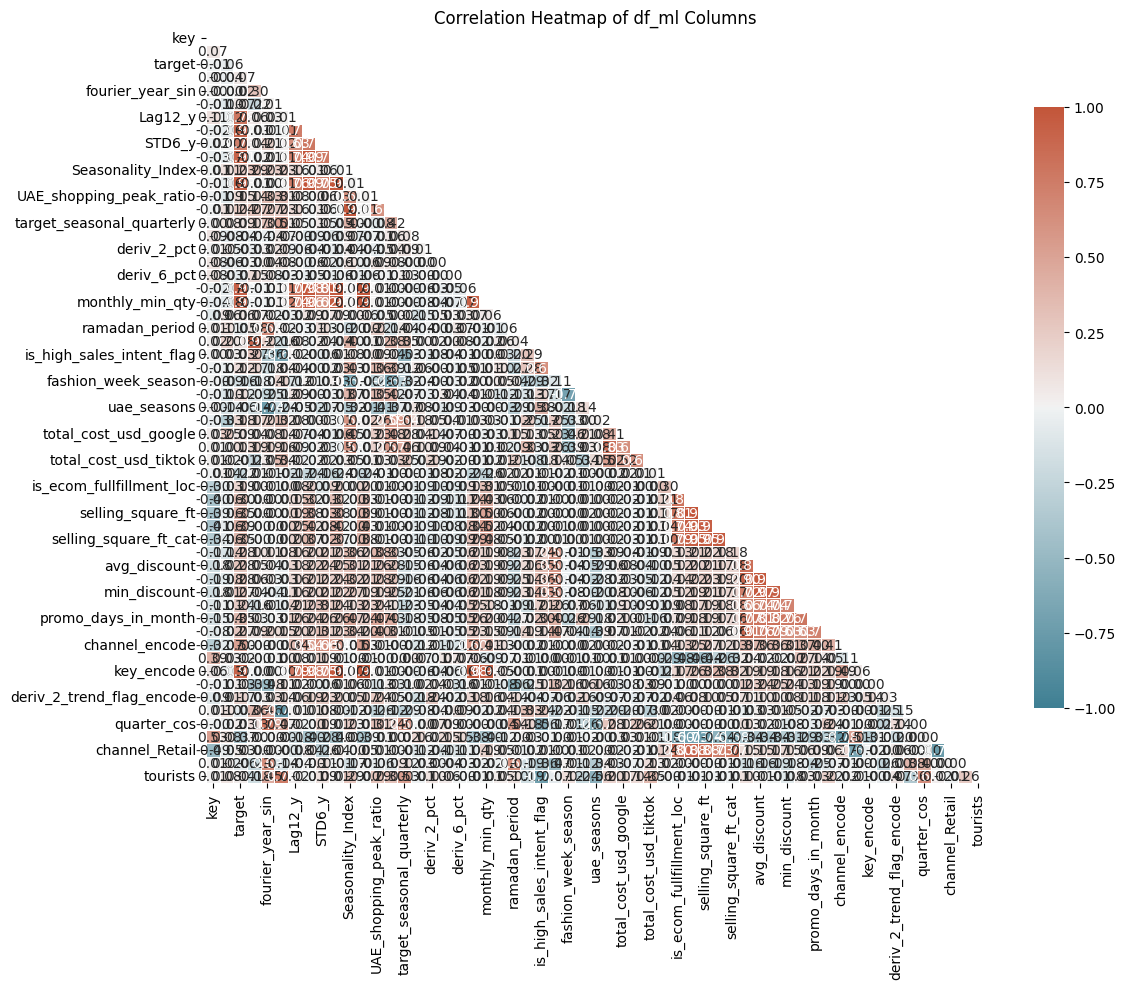

In [127]:
# df_ml.corr()
corr = df_ml.corr()

# 2. Mask the upper triangle to avoid duplicate information
mask = np.triu(np.ones_like(corr, dtype=bool))

# 3. Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    mask=mask,
    cmap=sns.diverging_palette(220, 20, as_cmap=True),
    vmin=-1, vmax=1,
    annot=True, fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap of df_ml Columns")
plt.tight_layout()
plt.show()

In [128]:
df_ml.columns

Index(['key', 'date', 'target', 'holiday_count', 'fourier_year_sin',
       'fourier_year_cos', 'Lag12_y', 'MA6_y', 'STD6_y', 'EMA6_y',
       'Seasonality_Index', 'rate_of_sale', 'UAE_shopping_peak_ratio',
       'target_seasonal_monthly', 'target_seasonal_quarterly', 'deriv_1_pct',
       'deriv_2_pct', 'deriv_3_pct', 'deriv_6_pct', 'monthly_max_qty',
       'monthly_min_qty', 'deriv_1_flag', 'ramadan_period', 'public_holidays',
       'is_high_sales_intent_flag', 'shopping_event_code',
       'fashion_week_season', 'count_of_days', 'uae_seasons',
       'total_cost_usd_facebook', 'total_cost_usd_google',
       'total_cost_usd_instagram', 'total_cost_usd_tiktok', 'city',
       'is_ecom_fullfillment_loc', 'total_square_ft', 'selling_square_ft',
       'total_square_ft_cat', 'selling_square_ft_cat',
       'distinct_discount_levels', 'avg_discount', 'max_discount',
       'min_discount', 'avg_promo_duration', 'promo_days_in_month',
       'percentage_products_on_promo', 'channel_enco

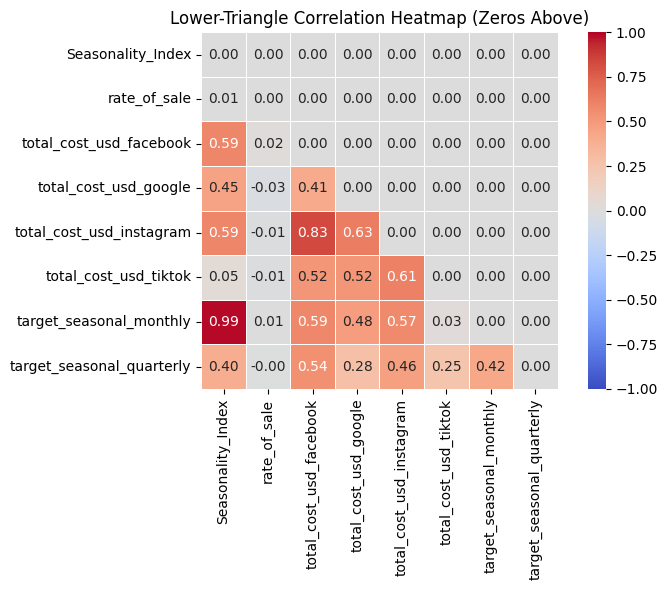

In [129]:
cols=['Seasonality_Index','rate_of_sale','total_cost_usd_facebook',
       'total_cost_usd_google', 'total_cost_usd_instagram',
       'total_cost_usd_tiktok', 'target_seasonal_monthly','target_seasonal_quarterly']

corr_df = df_ml[cols].corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool), k=0)
corr_masked = corr_df.mask(mask, other=0)

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_masked,
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    vmin=-1, vmax=1,
    linewidths=0.5, 
    square=True
)
plt.title("Lower-Triangle Correlation Heatmap (Zeros Above)")
plt.tight_layout()
plt.show()

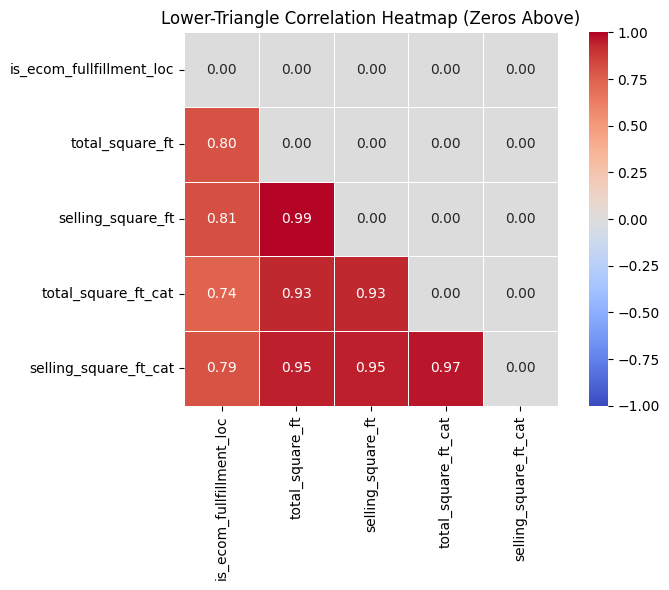

In [130]:
#store related features
cols=['is_ecom_fullfillment_loc', 'total_square_ft', 'selling_square_ft',
       'total_square_ft_cat', 'selling_square_ft_cat']

corr_df = df_ml[cols].corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool), k=0)
corr_masked = corr_df.mask(mask, other=0)

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_masked,
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    vmin=-1, vmax=1,
    linewidths=0.5, 
    square=True
)
plt.title("Lower-Triangle Correlation Heatmap (Zeros Above)")
plt.tight_layout()
plt.show()


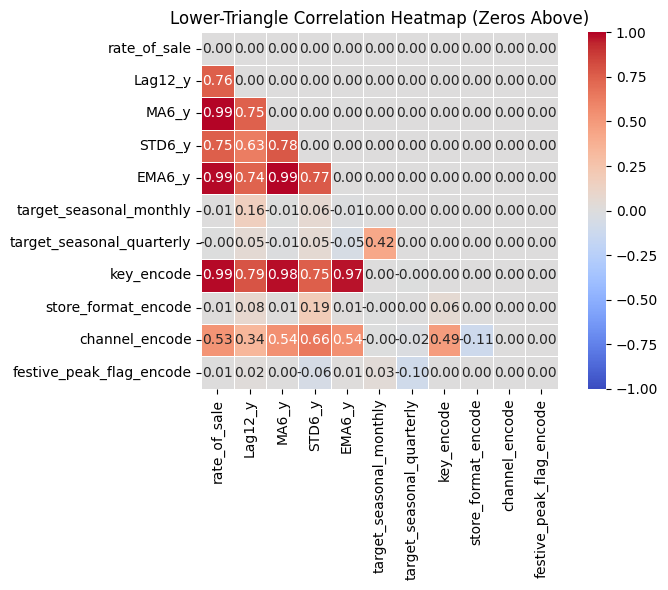

In [131]:
cols = ['rate_of_sale','Lag12_y','MA6_y','STD6_y','EMA6_y',
        'target_seasonal_monthly','target_seasonal_quarterly','key_encode',
        'store_format_encode','channel_encode','festive_peak_flag_encode']
corr_df = df_ml[cols].corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool), k=0)
corr_masked = corr_df.mask(mask, other=0)

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_masked,
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    vmin=-1, vmax=1,
    linewidths=0.5, 
    square=True
)
plt.title("Lower-Triangle Correlation Heatmap (Zeros Above)")
plt.tight_layout()
plt.show()

In [132]:
df_ml.drop(["rate_of_sale","target_seasonal_monthly","target_seasonal_quarterly","EMA6_y",'total_square_ft',\
           'total_square_ft_cat','monthly_max_qty', 'monthly_min_qty'],axis=1,inplace=True)


In [133]:
df_ml.columns

Index(['key', 'date', 'target', 'holiday_count', 'fourier_year_sin',
       'fourier_year_cos', 'Lag12_y', 'MA6_y', 'STD6_y', 'Seasonality_Index',
       'UAE_shopping_peak_ratio', 'deriv_1_pct', 'deriv_2_pct', 'deriv_3_pct',
       'deriv_6_pct', 'deriv_1_flag', 'ramadan_period', 'public_holidays',
       'is_high_sales_intent_flag', 'shopping_event_code',
       'fashion_week_season', 'count_of_days', 'uae_seasons',
       'total_cost_usd_facebook', 'total_cost_usd_google',
       'total_cost_usd_instagram', 'total_cost_usd_tiktok', 'city',
       'is_ecom_fullfillment_loc', 'selling_square_ft',
       'selling_square_ft_cat', 'distinct_discount_levels', 'avg_discount',
       'max_discount', 'min_discount', 'avg_promo_duration',
       'promo_days_in_month', 'percentage_products_on_promo', 'channel_encode',
       'store_format_encode', 'key_encode', 'festive_peak_flag_encode',
       'deriv_2_trend_flag_encode', 'quarter_sin', 'quarter_cos',
       'channel_Farfetch', 'channel_Reta

### save path

In [134]:
full_path = f"{gcs_path}/{target}/{brand}/{experiment_name}/{cutoff_month}/{train_end_date}/{file_output}"

In [135]:
full_path

'gs://trd-sf-ntb/units/LACOSTE/model_pipeline/2025-07/2024-10-31/feature_store.parquet'

In [136]:
df_ml.to_parquet(full_path,index=False)

In [137]:
hello

NameError: name 'hello' is not defined

In [ ]:
eda_features(df_ml,"features_store")